# Lecture Radiographies poumons, recherche pneumonies virales ou bactériennes, VGG16 Fine Tuning partiel 02

## 0. Import des librairies

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from pathlib import Path
from sklearn.metrics import confusion_matrix
import seaborn as sns

## 1. Paramétrage

In [16]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
CWD = Path.cwd()
NEW_TRAIN = CWD / "sorted_data" / "train"
NEW_VAL = CWD / "sorted_data" / "val"
NEW_TEST = CWD / "sorted_data" / "test"
class_names = {0: 'NORMAL', 1: 'VIRUS', 2: 'BACTERIA'}

## 2. Préparer les datasets avec augmentation des données

In [17]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.1,
    preprocessing_function=preprocess_input
)
train_dataset = train_datagen.flow_from_directory(
    directory=NEW_TRAIN,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_dataset = validation_datagen.flow_from_directory(
    directory=NEW_VAL,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_dataset = test_datagen.flow_from_directory(
    directory=NEW_TEST,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 12483 images belonging to 3 classes.
Found 288 images belonging to 3 classes.
Found 822 images belonging to 3 classes.


## 3. charger le modèle précédent my_model_finetuned_1.keras

In [18]:
model = load_model('my_model_finetuned_2.keras')

# Afficher les couches du modèle pour identifier la couche VGG16
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name}, {layer.__class__.__name__}")

Layer 0: input_layer_1, InputLayer
Layer 1: block1_conv1, Conv2D
Layer 2: block1_conv2, Conv2D
Layer 3: block1_pool, MaxPooling2D
Layer 4: block2_conv1, Conv2D
Layer 5: block2_conv2, Conv2D
Layer 6: block2_pool, MaxPooling2D
Layer 7: block3_conv1, Conv2D
Layer 8: block3_conv2, Conv2D
Layer 9: block3_conv3, Conv2D
Layer 10: block3_pool, MaxPooling2D
Layer 11: block4_conv1, Conv2D
Layer 12: block4_conv2, Conv2D
Layer 13: block4_conv3, Conv2D
Layer 14: block4_pool, MaxPooling2D
Layer 15: block5_conv1, Conv2D
Layer 16: block5_conv2, Conv2D
Layer 17: block5_conv3, Conv2D
Layer 18: block5_pool, MaxPooling2D
Layer 19: flatten_1, Flatten
Layer 20: flatten, Flatten
Layer 21: dense, Dense
Layer 22: dropout, Dropout
Layer 23: dense_1, Dense
Layer 24: dropout_1, Dropout
Layer 25: dense_2, Dense


## 4. Dégeler les couches 11 à 18 du modèle importé

In [19]:
# Dégeler plus de couches de VGG16
for layer in model.layers[:11]:  # Geler les premières couches de 0 à 10
    layer.trainable = False

for layer in model.layers[11:19]:  # Dégeler les couches de 11 à 18
    layer.trainable = True

## 5. Ajouter des couches supplémentaires avec Dropout et régularisation L2

In [20]:
x = model.layers[20].output  # Récupérer la sortie de la couche 19 (flatten)
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)  # 3 classes: NORMAL, BACTERIA, VIRUS

model = Model(inputs=model.input, outputs=output)

## 6. Recompiler le modèle avec un taux d'apprentissage plus faible

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall()])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,79

 Total params: 21,204,035 (80.89 MB)

 Trainable params: 19,468,547 (74.27 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

## 7. Ajout de l'early stopping et ajustement du taux d'apprentissage

In [22]:
# Callbacks pour l'entraînement
es = EarlyStopping(
    monitor="val_accuracy", 
    mode="max", 
    patience=10,
    restore_best_weights=True)

# Réduire le taux d'apprentissage si la perte sur l'ensemble de validation ne diminue pas
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

## 8. Continuer l'entraînement

In [23]:
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset, callbacks=[es, reduce_lr], shuffle=True)

Epoch 1/30


/home/neminounet/Documents/Epitech/T-DEV-810/EPI_DEV_810/env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/391 ━━━━━━━━━━━━━━━━━━━━ 1032s 3s/step - accuracy: 0.4684 - loss: 1.4502 - recall: 0.1604 - val_accuracy: 0.6771 - val_loss: 0.8965 - val_recall: 0.5868 - learning_rate: 1.0000e-04
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1083s 3s/step - accuracy: 0.6813 - loss: 0.9065 - recall: 0.6043 - val_accuracy: 0.6597 - val_loss: 0.8756 - val_recall: 0.6354 - learning_rate: 1.0000e-04
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 1049s 3s/step - accuracy: 0.7635 - loss: 0.7632 - recall: 0.7279 - val_accuracy: 0.6528 - val_loss: 0.8295 - val_recall: 0.6389 - learning_rate: 1.0000e-04
Epoch 4/30
366/391 ━━━━━━━━━━━━━━━━━━━━ 1:05 3s/step - accuracy: 0.7716 - loss: 0.7193 - recall: 0.7476

## 9. Évaluation du modèle

In [ ]:
test_loss, test_accuracy, test_recall = model.evaluate(test_dataset)
print(f"Loss on test dataset: {test_loss}")
print(f"Accuracy on test dataset: {test_accuracy}")
print(f"Recall on test dataset: {test_recall}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.8411 - loss: 0.6180 - recall: 0.8291
Loss on test dataset: 0.6529186964035034
Accuracy on test dataset: 0.8467153310775757
Recall on test dataset: 0.8345499038696289


## 10. Sauvegarde du modèle

In [ ]:
model.save('my_model_finetuned_3.keras')

## 11. Visualisation des courbes d'apprentissage

NameError: name 'history' is not defined

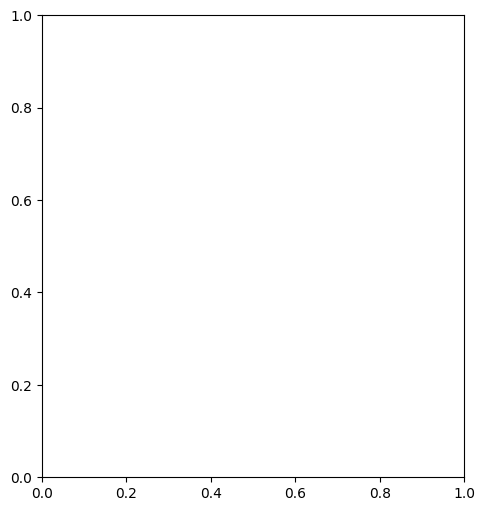

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Prédire les classes sur le jeu de test
test_labels = np.concatenate([y for x, y in test_dataset], axis=0)
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Calculer la matrice de confusion
cm = confusion_matrix(true_labels, predicted_labels)

# Tracer la heatmap de la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()